# Find identity term matches in data

See process_data.py

In [1]:
# Load incels data
import pandas as pd
import csv

path = '../../data/incels/all_comments.csv'
# data = pd.read_csv(path, engine='python', on_bad_lines=lambda x: print(x))
data = pd.read_csv(path, engine='python', on_bad_lines=lambda row: row[:-2].append(' '.join(row[-2:]))) # combine last 2 elements in a line mentioning Gulag
data['parsed_date'] = pd.to_datetime(data.date, errors='coerce') # "yesterday" etc not handled
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6248230 entries, 0 to 6248229
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   type         object        
 1   forum        object        
 2   thread       object        
 3   username     object        
 4   date         object        
 5   content      object        
 6   parsed_date  datetime64[ns]
dtypes: datetime64[ns](1), object(6)
memory usage: 333.7+ MB


## NetMapper identity term list

In [2]:
# Load identity terms
import pandas as pd

nm_identities_path = '../resources/generic_agents-identity_v15_2021_10_15.xlsx'
multi_identities = pd.read_excel(nm_identities_path)
multi_identities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19887 entries, 0 to 19886
Columns: 156 entries, Akan to Category 4
dtypes: float64(56), int64(1), object(99)
memory usage: 23.7+ MB


In [3]:
# Filter to English, remove duplicates
cols = multi_identities.columns.tolist()
en_identities = multi_identities[cols[cols.index('English'):]]
en_identities['term'] = en_identities['English'].str.lower()
en_identities.drop_duplicates(subset='term', inplace=True)
en_identities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19035 entries, 0 to 19886
Data columns (total 44 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   English          19035 non-null  object 
 1   conceptTo        19035 non-null  object 
 2   metaOntology     19035 non-null  object 
 3   nodeType         0 non-null      float64
 4   Category 1       9703 non-null   object 
 5   Category 2       911 non-null    object 
 6   Category 3       18929 non-null  object 
 7   Country          4712 non-null   object 
 8   First Name       0 non-null      float64
 9   Last Name        0 non-null      float64
 10  Gender           759 non-null    object 
 11  Suffix           0 non-null      float64
 12  Language         0 non-null      float64
 13  Acronym          336 non-null    object 
 14  Valence          19035 non-null  object 
 15  Evaluation       19035 non-null  int64  
 16  Potency          10 non-null     float64
 17  Activity    

/tmp/ipykernel_3944204/3338936415.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  en_identities['term'] = en_identities['English'].str.lower()
/tmp/ipykernel_3944204/3338936415.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  en_identities.drop_duplicates(subset='term', inplace=True)


In [18]:
# Separate out stopwords
stops = en_identities[en_identities['stop word']==1]
exclude_list = ['don', 'other', 'others', 'friend', 'friends', 'people', 'who', 'asshole', 'dick',
               'character', 'person', 'people', 'majority', 'bot', 'everyone', 'everyone here',
                'officially', 'tech', 'individual', 'worker', 'workers', 'giant', 'human', 'humans', 'ass',
                'nobody', 'brother', 'sister', 'mother', "mother's", 'father', 'daughter', 'son', 'mom', 'wife', 'wives', 'husband', 'husbands', 'cousin', 'cousins',
                'they all', 'count', 'god', 'general', 'user', 'users', 'member', 'members', 'english', 'finish', 'slayer', 'speaker',
                'misogynist', 'king', 'queen', 'rn', 'fellow', 'buddy', 'enemies', 'corpse', 'revolutionary', 'gymnast', 'messiah', 'jesus', 'embryo',
                'dr', 'doctor', 'dahmer', 'characters', 'cheat', 'sexist', 'professional', 'client', 'mate', 'dad', 'customers', 'assholes', 'whose',
                'mama', 'co-workers', 'employees', 'uncle', 'hermit', 'ogre', 'potter', 'phantom', 'dwellers', 'saviour', 'prophet', 'morons', 'guide',
                'majors', 'partners', 'villain', 'agent', 'model', 'juggernaut', 'ego', 'avatar', 'player', 'dragon', 'pm', 'winner', 'winners', 'surrogate', 'nudes',
               ]
exclude = en_identities[en_identities['term'].isin(exclude_list)]
identities = en_identities[(en_identities['stop word']!=1) & (~en_identities['term'].isin(exclude_list))]

# Search for identity matches
import re

pats = [re.compile(r'\b{}\b'.format(re.escape(term))) for term in identities['term']]
print(len(pats))

def contains_match(text):
    """ Return matched patterns present in text """ 
    return [re.search(p, str(text).lower()).group() for p in pats if re.search(p, str(text).lower()) is not None]

from collections import Counter

sample = data.sample(1000)

18837


In [8]:
# Filter to terms present at least once in the combined text (make this as fast as possible)
# vocab = set(data.content.astype('str').str.lower().str.split().sum()) # doesn't tokenize (remove punct) but whatever
vocab = set()
data.content.astype('str').str.lower().str.split().apply(vocab.update)
len(vocab)

1782573

In [19]:
from tqdm.notebook import tqdm

present_terms = [term for term in identities['term'] if term in vocab]
len(present_terms)

5564

In [21]:
pats_combo = re.compile(r'|'.join([(r'\b{}\b'.format(re.escape(term.lower()))) for term in present_terms]))
# pats_combo

def contains_match(text):
    """ Return matched patterns present in text """ 
    return re.findall(pats_combo, str(text).lower())

In [21]:
%%timeit -n 1 -r 1
# With separate re.search

sample['nm_identity_matches'] = sample.content.map(contains_match)
# sample[sample.nm_identity_matches.str.len() > 0]

58.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [22]:
# %%timeit -n 1 -r 3
# With combined re

sample['nm_identity_matches'] = sample.content.map(contains_match)
# sample[sample.nm_identity_matches.str.len() > 0]

In [23]:
identity_ctr = Counter(sample.nm_identity_matches.sum())
identity_ctr.most_common()

[('women', 78),
 ('man', 55),
 ('men', 55),
 ('jews', 27),
 ('bro', 26),
 ('female', 24),
 ('girls', 22),
 ('woman', 20),
 ('male', 19),
 ('jew', 15),
 ('virgin', 15),
 ('males', 14),
 ('whore', 14),
 ('whores', 14),
 ('girl', 14),
 ('intellectual', 14),
 ('females', 13),
 ('dude', 13),
 ('intellectuals', 13),
 ('arabs', 11),
 ('asian', 11),
 ('nigger', 10),
 ('faggot', 10),
 ('feminist', 9),
 ('niggers', 9),
 ('subhuman', 8),
 ('child', 8),
 ('christian', 8),
 ('girlfriend', 7),
 ('arab', 7),
 ('leftist', 7),
 ('chinese', 6),
 ('muslim', 6),
 ('asians', 6),
 ('nazi', 6),
 ('enemy', 5),
 ('dudes', 5),
 ('catholic', 5),
 ('fag', 5),
 ('boyfriend', 5),
 ('indian', 5),
 ('european', 5),
 ('kid', 5),
 ('scum', 4),
 ('driver', 4),
 ('indians', 4),
 ('christ', 4),
 ('socialist', 4),
 ('hookers', 4),
 ('virgins', 4),
 ('kids', 4),
 ('sluts', 4),
 ('racist', 4),
 ('leader', 4),
 ('socialists', 4),
 ('american', 4),
 ('bitch', 4),
 ('brits', 3),
 ('jerk', 3),
 ('teacher', 3),
 ('hunter', 3),
 (

# Visualize identity term matches

In [27]:
freq = pd.DataFrame(identity_ctr.most_common(), columns=['term', 'count'])
freq

,term,count
0,women,78
1,man,55
2,men,55
3,jews,27
4,bro,26
...,...,...
419,girlfriends,1
420,everyones,1
421,communists,1
422,pilots,1


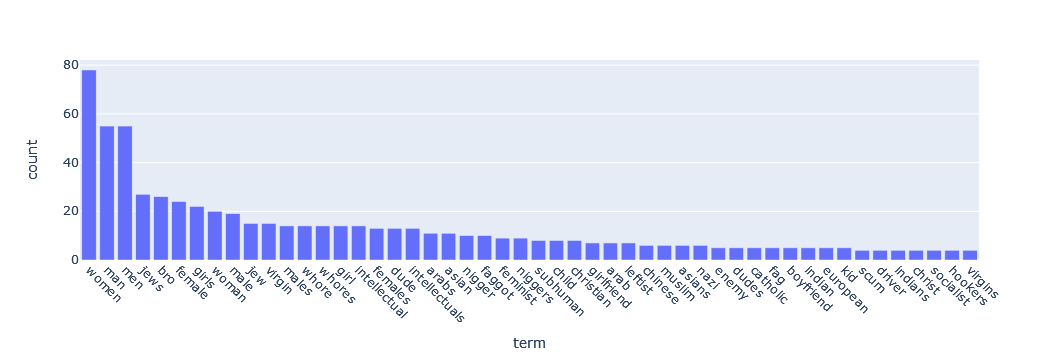

In [32]:
import plotly.express as px
pd.options.plotting.backend = 'plotly'

fig = px.bar(freq.head(50), x='term', y='count')
fig.update_xaxes(tickangle=45)

In [ ]:
# Top terms over time (will have to bin by month or something)